# DataKind Red Cross Project Phase 2
## Home Fire Risk Data Model
10/28/2019
Tasks:
1. <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
2. <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
3. <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.
4. <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates
5. <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

In [129]:
nfirs_top = pd.read_csv(nfirs_path, encoding='latin-1',nrows=1000)

In [130]:
nfirs_top.head()

,ID,state,fdid,inc_no,city,street,zip5,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail,COUNTYFP,FUNCSTAT,GEOID,MATCH,MATCHED_ADDRESS,MATCH_TYPE,MTFCC,NAME,NAMELSAD,ORIGINAL_ADDRESS,STATE,TIGER_LINE_ID,TIGER_LINE_SIDE,TRACTCE,X,Y,state_fips
0,rcp2_id1,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,1/3/2009 0:00:00,0.0,0.0,0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN,110.0,S,2.110000e+09,Match,"1700 ANGUS WAY, JUNEAU, AK, 99801",Exact,G5020,5.0,Census Tract 5,"1700 ANGUS WAY, JUNEAU, AK, 99801",AK,190964136.0,R,500.0,-134.42440,58.306507,2.0
1,rcp2_id2,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,1/6/2009 0:00:00,0.0,0.0,0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,S,2.110001e+09,Match,"3221 PIONEER AVE, JUNEAU, AK, 99801",Exact,G5020,6.0,Census Tract 6,"3221 PIONEER AVE, JUNEAU, AK, 99801",AK,190966361.0,R,600.0,-134.43314,58.292686,2.0
2,rcp2_id3,AK,11100,556,JUNEAU,10231 HERON WAY,99801,1/6/2009 0:00:00,0.0,0.0,0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,110.0,S,2.110000e+09,Match,"10231 HERON WAY, JUNEAU, AK, 99801",Exact,G5020,1.0,Census Tract 1,"10231 HERON WAY, JUNEAU, AK, 99801",AK,190962538.0,R,100.0,-134.60330,58.402610,2.0
3,rcp2_id4,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,1/13/2009 0:00:00,0.0,0.0,0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,S,2.110000e+09,Match,"6590 Glacier Hwy, JUNEAU, AK, 99801",Exact,G5020,4.0,Census Tract 4,"6590 GLACIER HWY, JUNEAU, AK, 99801",AK,190963741.0,R,400.0,-134.51932,58.358955,2.0
4,rcp2_id5,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,1/21/2009 0:00:00,0.0,0.0,0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,110.0,S,2.110000e+09,Match,"6590 Glacier Hwy, JUNEAU, AK, 99801",Exact,G5020,4.0,Census Tract 4,"6590 GLACIER HWY, JUNEAU, AK, 99801",AK,190963741.0,R,400.0,-134.51932,58.358955,2.0


# 1. Data Import and Cleaning

## 1.1 NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [2]:
nfirs_path = '../data/01_raw/NFIRS_2009_2016_Combined_Census_Tract.csv'

cols_to_use = ['inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

In [ ]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [3]:
nfirs.sample(5)

,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID
1856512,2016-10-11,1.0,0.0,3000.0,4000.0,7000.0,22051025104.0
978989,2013-12-23,NaN,NaN,3000.0,0.0,3000.0,NaN
1298757,2014-12-05,NaN,NaN,0.0,0.0,0.0,25017310100.0
718729,2011-10-15,0.0,0.0,0.0,0.0,0.0,48441012802.0
1214388,2014-04-11,NaN,NaN,50000.0,20000.0,70000.0,1073011804.0


## 1.2 Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [4]:
nfirs['GEOID'].str.len().value_counts()

13.0    1442479
12.0     196432
Name: GEOID, dtype: int64

In [5]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2]
                  .str.zfill(11))

In [6]:
nfirs.head()

,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID
0,2009-01-03,0.0,0.0,20000.0,5000.0,25000.0,02110000500
1,2009-01-06,0.0,0.0,0.0,0.0,0.0,02110000600
2,2009-01-06,0.0,0.0,20000.0,5000.0,25000.0,02110000100
3,2009-01-13,0.0,0.0,200.0,20.0,220.0,02110000400
4,2009-01-21,0.0,0.0,35000.0,5000.0,40000.0,02110000400


In [7]:
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year

## 1.3 SVI Data

In [8]:
svi2016_path = '../data/01_raw/SVI2016_US.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)

In [9]:
svi2016.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.644448,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,335.0
1,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.929908,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0
2,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0


# 2. Tasks 1 & 3

- Task 1: <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 3: <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.

In [10]:
# add the state+county unique identifier column to nfirs
nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_counties = pd.crosstab(nfirs['STCNTY'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_counties[(year,'tot_fires')] = nfirs_counties[(year,'not_sev_fire')] + nfirs_counties[(year,'sev_fire')]

# Sort the columns
nfirs_counties = nfirs_counties[sorted(nfirs_counties.columns)]

# aggregate svi data by county
svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_counties_rates = nfirs_svi_counties[['E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_counties_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_counties[(year,'tot_fires')] / nfirs_svi_counties['E_TOTPOP']
    nfirs_svi_counties_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_counties[(year,'sev_fire')] / nfirs_svi_counties['E_TOTPOP']

# Add the county and state columns to the dataset
nfirs_svi_counties_rates = nfirs_svi_counties_rates.merge(svi2016[['COUNTY','ST_ABBR','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
nfirs_svi_counties_rates = nfirs_svi_counties_rates.set_index('STCNTY')

# create list of severe columns & total columns
sev_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].mean(axis=1)
nfirs_svi_counties_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].std(axis=1)
nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].mean(axis=1)
nfirs_svi_counties_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_counties_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_counties_rates = nfirs_svi_counties_rates[cols]

In [102]:
nfirs_svi_counties_rates.head()

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
01001,AL,Autauga,55049.0,0.000459,0.000164,0.000170,0.000166,0.000708,0.000236,0.000490,0.000163,0.000527,0.000127,0.000254,0.000036,0.000436,0.000073,0.000200,0.000036,0.000563,0.000545,0.000490,0.000145
01003,AL,Baldwin,199510.0,0.000465,0.000099,0.000134,0.000150,0.000366,0.000080,0.000471,0.000075,0.000381,0.000100,0.000441,0.000065,0.000396,0.000050,0.000677,0.000125,0.000501,0.000501,0.000486,0.000075
01005,AL,Barbour,26614.0,0.000244,0.000143,0.000085,0.000089,0.000376,0.000113,0.000451,0.000000,0.000150,0.000000,0.000301,0.000188,0.000038,0.000000,0.000338,0.000225,0.000113,0.000113,0.000188,0.000038
01007,AL,Bibb,22572.0,0.000072,0.000062,0.000044,0.000033,0.000044,0.000044,0.000044,0.000044,0.000089,0.000044,0.000177,0.000044,0.000000,0.000000,0.000000,0.000000,0.000089,0.000089,0.000133,0.000089
01009,AL,Blount,57704.0,0.000390,0.000196,0.000121,0.000086,0.000364,0.000069,0.000399,0.000069,0.000468,0.000243,0.000277,0.000087,0.000208,0.000069,0.000295,0.000069,0.000277,0.000277,0.000832,0.000087


### Save fire rates by county

In [68]:
nfirs_svi_counties_rates.to_csv('../data/02_interim/Per_capita_fire_rates_by_county.csv')

# 3. Tasks 2 & 4

- Task 2: <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 4: <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population 

In [120]:
# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_tracts = pd.crosstab(nfirs['GEOID'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in nfirs['year'].unique():
    nfirs_tracts[(year,'tot_fires')] = nfirs_tracts[(year,'not_sev_fire')] + nfirs_tracts[(year,'sev_fire')]

# Sort the columns
nfirs_tracts = nfirs_tracts[sorted(nfirs_tracts.columns)]

# data already aggregated by census tract, so simply select the columns to merge
svi2016_tracts = svi2016[['FIPS','ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].set_index('FIPS')

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_tracts = svi2016_tracts.merge(nfirs_tracts,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_tracts_rates = nfirs_svi_tracts[['ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_tracts_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'tot_fires')] / nfirs_svi_tracts['E_TOTPOP']
    nfirs_svi_tracts_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'sev_fire')] / nfirs_svi_tracts['E_TOTPOP']

nfirs_svi_tracts_rates.index.name = 'GEOID'

# create list of severe columns & total columns
sev_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_tracts_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].std(axis=1)
nfirs_svi_tracts_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','LOCATION','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_tracts_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_tracts_rates = nfirs_svi_tracts_rates[cols]

C:\Users\thwhi\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [125]:
nfirs_svi_tracts_rates.sample(5)

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
20209041600,KS,Wyandotte,4277.0,"Census Tract 416, Wyandotte County, Kansas",0.001286,0.000952,0.000643,0.000541,0.000935,0.000468,0.002104,0.000468,0.001637,0.000935,0.001169,0.000701,0.003040,0.001637,0.000234,0.000000,0.000935,0.000935,0.000234,0.0
48439123100,TX,Tarrant,3076.0,"Census Tract 1231, Tarrant County, Texas",0.003129,0.001544,0.001666,0.001826,0.004226,0.003251,0.002276,0.000975,0.002926,0.000650,0.004226,0.000975,0.002276,0.000650,0.002276,0.001300,0.005852,0.005527,0.000975,0.0
12073000200,FL,Leon,3993.0,"Census Tract 2, Leon County, Florida",0.001127,0.000518,0.000344,0.000266,0.000751,0.000250,0.001252,0.000501,0.000501,0.000250,0.002004,0.000000,0.001503,0.000501,0.001503,0.000501,0.000751,0.000751,0.000751,0.0
09011660102,CT,New London,4299.0,"Census Tract 6601.02, New London County, Conne...",0.000116,0.000176,0.000000,0.000000,0.000465,0.000000,0.000000,0.000000,0.000233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000233,0.000000,0.000000,0.000000,0.000000,0.0
42041011803,PA,Cumberland,7287.0,"Census Tract 118.03, Cumberland County, Pennsy...",0.000446,0.000241,0.000103,0.000241,0.000274,0.000000,0.000549,0.000000,0.000686,0.000000,0.000000,0.000000,0.000549,0.000137,0.000549,0.000000,0.000686,0.000686,0.000274,0.0


### Save fire rates by census_tract

In [124]:
nfirs_svi_counties_rates.to_csv('../data/02_interim/Per_capita_fire_rates_by_census_tract.csv')

In [155]:
test = pd.read_csv('../data/02_interim/Per_capita_fire_rates_by_census_tract.csv')
test.sample(5)

,STCNTY,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
217,6063,CA,Plumas,18754.0,0.000813,0.000270,0.000213,0.000178,0.000800,0.000107,0.000747,0.000213,0.001120,0.000213,0.000480,0.000160,0.000853,0.000160,0.000587,0.000107,0.000640,0.000640,0.001280,0.000107
1173,22121,LA,West Baton Rouge,25017.0,0.000435,0.000234,0.000115,0.000097,0.000000,0.000000,0.000480,0.000080,0.000680,0.000080,0.000280,0.000040,0.000680,0.000200,0.000520,0.000040,0.000280,0.000240,0.000560,0.000240
1883,36111,NY,Ulster,180505.0,0.000665,0.000304,0.000127,0.000274,0.000543,0.000028,0.000560,0.000050,0.000033,0.000000,0.000737,0.000028,0.000709,0.000017,0.000864,0.000055,0.000814,0.000803,0.001058,0.000033
2286,42085,PA,Mercer,114598.0,0.000269,0.000142,0.000051,0.000086,0.000079,0.000009,0.000227,0.000009,0.000480,0.000026,0.000271,0.000026,0.000209,0.000035,0.000148,0.000026,0.000271,0.000262,0.000471,0.000017
2405,46089,SD,McPherson,2252.0,0.000056,0.000157,0.000056,0.000157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000444,0.000444,0.000000,0.000000


# 4. Task 5
- Task 5: <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

1 year intervals will be used to capture the temporal aspect of the data, which occurs at one year intervals (most fires occur during the winter months)

## 4.1 Plotting correlation coefficients

In [35]:
def plot_correlation_matrix_heat_map(df,label,qty_fields=10):
    df = pd.concat([df[label],df.drop(label,axis=1)],axis=1)
    correlation_matrix = df.corr()
    index = correlation_matrix.sort_values(label, ascending=False).index
    correlation_matrix = correlation_matrix[index].sort_values(label,ascending=False)

    fig,ax = plt.subplots()
    fig.set_size_inches((10,10))
    sns.heatmap(correlation_matrix.iloc[:qty_fields,:qty_fields],annot=True,fmt='.2f',ax=ax)
    return(fig,ax)

### 4.1.1 County correlation heat maps

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2ce5a1bf4a8>)

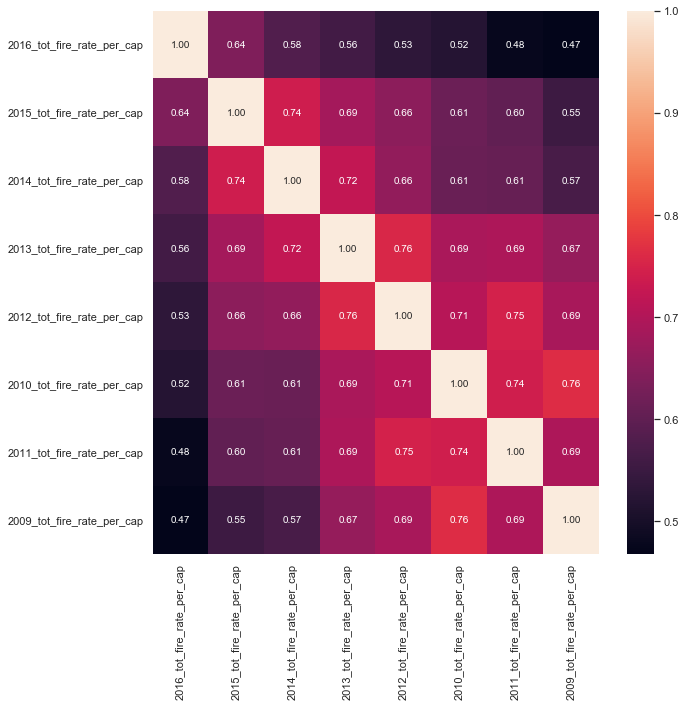

In [37]:
plot_correlation_matrix_heat_map(nfirs_svi_counties_rates[tot_cols],'2016_tot_fire_rate_per_cap')

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2ce59fdca90>)

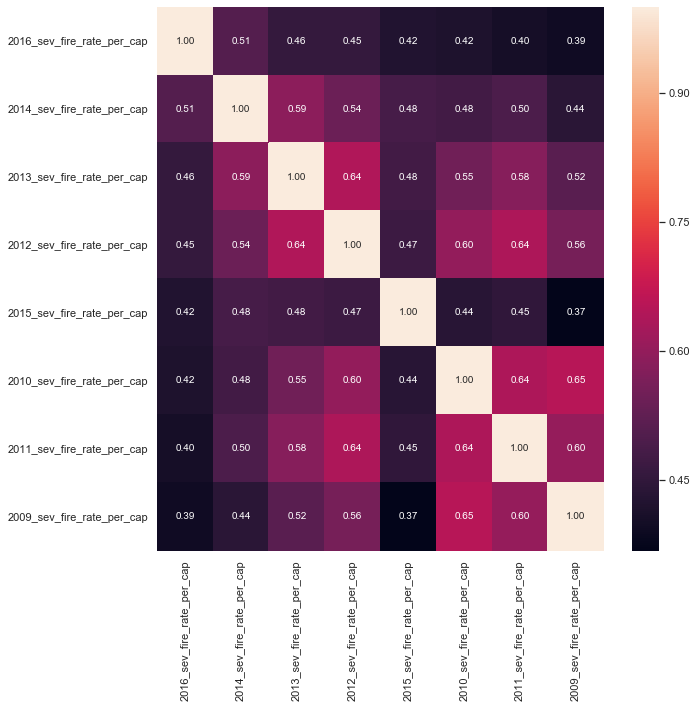

In [42]:
plot_correlation_matrix_heat_map(nfirs_svi_counties_rates[sev_cols],'2016_sev_fire_rate_per_cap')

### 4.1.2 Census tract correlation heat maps

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2ce50f31518>)

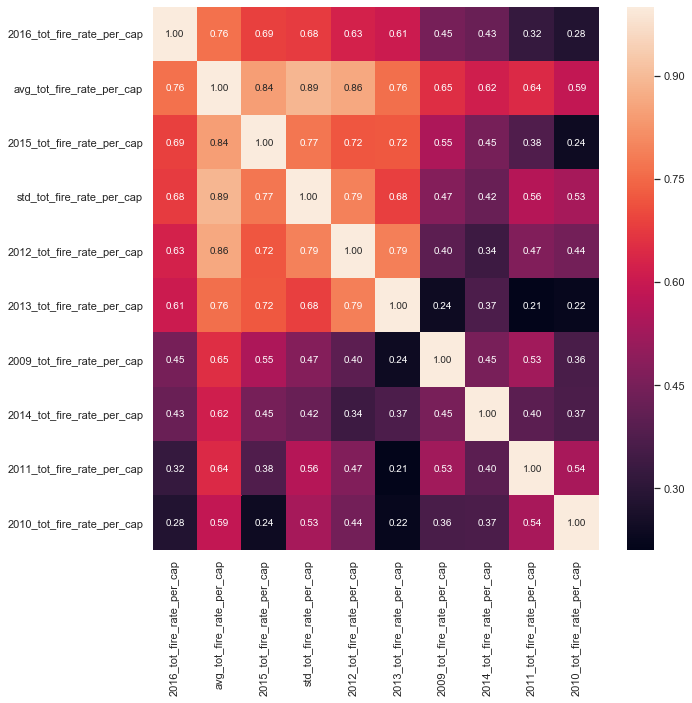

In [116]:
plot_correlation_matrix_heat_map(nfirs_svi_tracts_rates[tot_cols],'2016_tot_fire_rate_per_cap')

## Linear Regression Model

In [135]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

I'll use the yearly aggregated rates to create a simple linear regression algorithm to predict the rate for 2016 by census tract

In [137]:
def null_counts(df):
    null_df = pd.DataFrame(df.isnull().sum(),columns=['null_count'])
    null_df['null_fraction'] = null_df['null_count'] / df.shape[0]
    null_df = null_df.sort_values('null_count',ascending=False)
    return null_df

In [138]:
null_counts(nfirs_svi_tracts_rates)

,null_count,null_fraction
2013_sev_fire_rate_per_cap,4750,0.065215
2012_sev_fire_rate_per_cap,4750,0.065215
std_tot_fire_rate_per_cap,4750,0.065215
std_sev_fire_rate_per_cap,4750,0.065215
2009_sev_fire_rate_per_cap,4750,0.065215
2014_sev_fire_rate_per_cap,4749,0.065201
2010_sev_fire_rate_per_cap,4749,0.065201
2011_sev_fire_rate_per_cap,4748,0.065188
2016_sev_fire_rate_per_cap,4747,0.065174
2009_tot_fire_rate_per_cap,4747,0.065174


In [132]:
tot_cols

Index(['2009_tot_fire_rate_per_cap', '2010_tot_fire_rate_per_cap',
       '2011_tot_fire_rate_per_cap', '2012_tot_fire_rate_per_cap',
       '2013_tot_fire_rate_per_cap', '2014_tot_fire_rate_per_cap',
       '2015_tot_fire_rate_per_cap', '2016_tot_fire_rate_per_cap'],
      dtype='object')

In [151]:
label = '2016_tot_fire_rate_per_cap'
# features = tot_cols.drop(label)
features = ['2014_tot_fire_rate_per_cap','2015_tot_fire_rate_per_cap']

X_train, X_test, y_train, y_test = train_test_split(nfirs_svi_tracts_rates.dropna()[features],nfirs_svi_tracts_rates.dropna()[label],train_size=.8,random_state=1)

In [152]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train,random_state=1)

In [153]:
lr = LinearRegression()
lr.fit(X_train2,y_train2)
lr.score(X_train2,y_train2)

0.6103114199095088

In [154]:
lr = LinearRegression()
cross_val_score(lr,X_train,y_train,cv=10)

array([ 0.43255515,  0.34956002,  0.38157443,  0.77108122,  0.42177448,
        0.68032207,  0.35967215, -0.15691824,  0.45037743,  0.37971549])

In [128]:
nfirs_svi_tracts_rates.sample(5,random_state=1)

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
36063022100,NY,Niagara,2360.0,"Census Tract 221, Niagara County, New York",0.000583,0.000503,0.000212,0.000320,0.000847,0.000424,0.000000,0.000000,0.000000,0.000000,0.001271,0.000000,0.000847,0.000424,0.000000,0.000000,0.000847,0.000847,0.000847,0.000000
36005002800,NY,Bronx,5350.0,"Census Tract 28, Bronx County, New York",0.002126,0.000519,0.000047,0.000132,0.002430,0.000000,0.001495,0.000000,0.001308,0.000000,0.002243,0.000000,0.002430,0.000000,0.002430,0.000000,0.002804,0.000374,0.001869,0.000000
27109002100,MN,Olmsted,6400.0,"Census Tract 21, Olmsted County, Minnesota",0.000078,0.000221,0.000020,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000625,0.000156,0.000000,0.000000,0.000000,0.000000
36047089800,NY,Kings,1676.0,"Census Tract 898, Kings County, New York",0.007757,0.008775,0.000597,0.001462,0.002387,0.000000,0.001193,0.000000,0.001193,0.000000,0.001193,0.000000,0.001193,0.000000,0.016706,0.000000,0.019690,0.004177,0.018496,0.000597
39093010300,OH,Lorain,5416.0,"Census Tract 103, Lorain County, Ohio",0.000923,0.000503,0.000300,0.000355,0.000554,0.000000,0.002031,0.000185,0.000739,0.000369,0.001108,0.000369,0.000554,0.000185,0.000739,0.000185,0.001108,0.001108,0.000554,0.000000
